In [3]:
### Experimental Design:

# In the beginning of the AB test, we define a hypothesis, which states what difference we expect with our test.(effect size)
# Our pre-experiment ARPDAU is $0.05, so that it is our baseline value.
# We are expecting around a + $0.01 difference brought by our new design, this is our effect size. 

# We perform a Power Analysis in order to determine a "sample size" before the experiment.
# In a Power Analysis, we would need:
# Baseline value(ARPDAU), effect size, proportion of data(~0.50), alpha(significance level)=0.05, power=0.80
# power: is the probability to reject the null hypothesis.

# We use a t-test for Power Analysis:

install.packages("pwr")
library(pwr)
pwr.t.test(power=0.8, sig.level=0.05, d=0.01)

# Result: sample size > 156,978 for each group.

Installing package into 'C:/Users/Dell/Documents/R/win-library/3.6'
(as 'lib' is unspecified)
Warning message:
"package 'pwr' is in use and will not be installed"


     Two-sample t test power calculation 

              n = 156978.2
              d = 0.01
      sig.level = 0.05
          power = 0.8
    alternative = two.sided

NOTE: n is number in *each* group


In [6]:
# Importing the datasets and observing the relationships.

library(readr)
data_activity <- read_csv("C:/Users/Dell/Desktop/Game Analytics/data_daily_activity.csv")
head(data_activity)
data_iap <- read_csv("C:/Users/Dell/Desktop/Game Analytics/data_in_app_purchases.csv")
head(data_iap)

Parsed with column specification:
cols(
  dateActivity = col_date(format = ""),
  abTestGroup = col_character(),
  platform = col_character(),
  countryCode = col_character(),
  userId = col_character()
)


dateActivity,abTestGroup,platform,countryCode,userId
2018-12-12,group_control,iOS,US,4e3a15wton1nlyy
2018-12-11,group_control,Android,US,z8tolnt91mfcrp6
2018-12-11,group_control,Android,RO,mxhd5t4zuudj8wb
2018-12-13,group_test,iOS,SE,j5o1mibvw5wjl46
2018-12-08,group_test,Android,IL,mu9bdbizv82yfj5
2018-12-08,group_control,Android,PK,thauz32vnbgh5se


Parsed with column specification:
cols(
  dateActivity = col_date(format = ""),
  productId = col_character(),
  cost = col_double(),
  userId = col_character()
)


dateActivity,productId,cost,userId
2018-12-13,specialpack1_0,0.398,945e93rhoaf2mwh
2018-12-08,specialpack1_0,0.398,ud0htw81k1whtvd
2018-12-12,poolcash005,9.998,efyc6a2edesfyno
2018-12-10,specialpack,0.198,988ade0dpe0hij1
2018-12-09,coinpack001,0.398,iu0su7ko0nzukmp
2018-12-08,specialpack1_0,0.398,ik337qn9jyxdram


In [7]:
# Joining the 2 tables
# Since our test&control group classification is in the data_activity table, it becomes the "left" table.
# There are 2 keys to join: dateActivity and userId

library(tidyverse)
data_joined <- data_activity %>% 
  left_join(data_iap, by=c("dateActivity","userId"))
str(data_joined)
sum(is.na(data_joined$cost))

### 484K of 522K values of "cost" column are NA ! 

Warning message:
"package 'tidyverse' was built under R version 3.6.3"-- Attaching packages --------------------------------------- tidyverse 1.3.0 --
v ggplot2 3.3.0     v dplyr   0.8.5
v tibble  2.1.3     v stringr 1.4.0
v tidyr   1.0.2     v forcats 0.5.0
v purrr   0.3.3     
Warning message:
"package 'tidyr' was built under R version 3.6.3"Warning message:
"package 'purrr' was built under R version 3.6.3"Warning message:
"package 'dplyr' was built under R version 3.6.3"Warning message:
"package 'forcats' was built under R version 3.6.3"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Classes 'spec_tbl_df', 'tbl_df', 'tbl' and 'data.frame':	522685 obs. of  7 variables:
 $ dateActivity: Date, format: "2018-12-12" "2018-12-11" ...
 $ abTestGroup : chr  "group_control" "group_control" "group_control" "group_test" ...
 $ platform    : chr  "iOS" "Android" "Android" "iOS" ...
 $ countryCode : chr  "US" "US" "RO" "SE" ...
 $ userId      : chr  "4e3a15wton1nlyy" "z8tolnt91mfcrp6" "mxhd5t4zuudj8wb" "j5o1mibvw5wjl46" ...
 $ productId   : chr  NA NA NA NA ...
 $ cost        : num  NA NA NA NA NA 0.798 NA NA NA 0.798 ...


[1] 484229

In [8]:
# Solution for NA values: We will replace NA values with zero for the numeric "cost" column.

data_clean <- data_joined %>% replace_na(list(cost=0))
summary(data_clean)

### Mean of all experimental data is $ 0.05

  dateActivity        abTestGroup          platform         countryCode       
 Min.   :2018-12-07   Length:522685      Length:522685      Length:522685     
 1st Qu.:2018-12-08   Class :character   Class :character   Class :character  
 Median :2018-12-10   Mode  :character   Mode  :character   Mode  :character  
 Mean   :2018-12-10                                                           
 3rd Qu.:2018-12-12                                                           
 Max.   :2018-12-13                                                           
    userId           productId              cost         
 Length:522685      Length:522685      Min.   : 0.00000  
 Class :character   Class :character   1st Qu.: 0.00000  
 Mode  :character   Mode  :character   Median : 0.00000  
                                       Mean   : 0.05673  
                                       3rd Qu.: 0.00000  
                                       Max.   :19.99800  

Warning message:
"package 'lubridate' was built under R version 3.6.3"
Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date



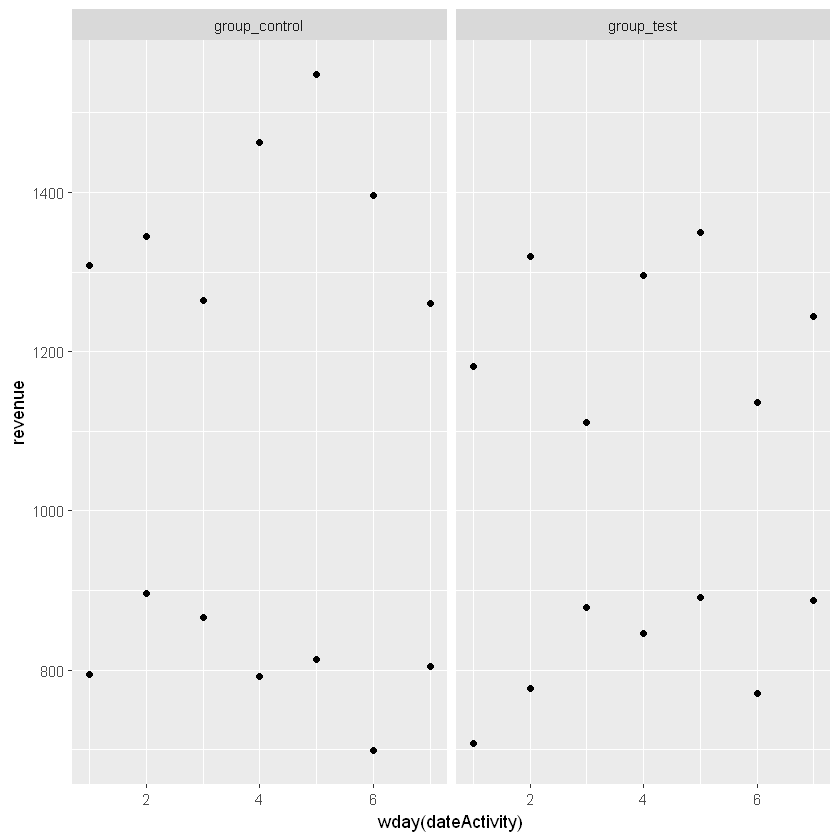

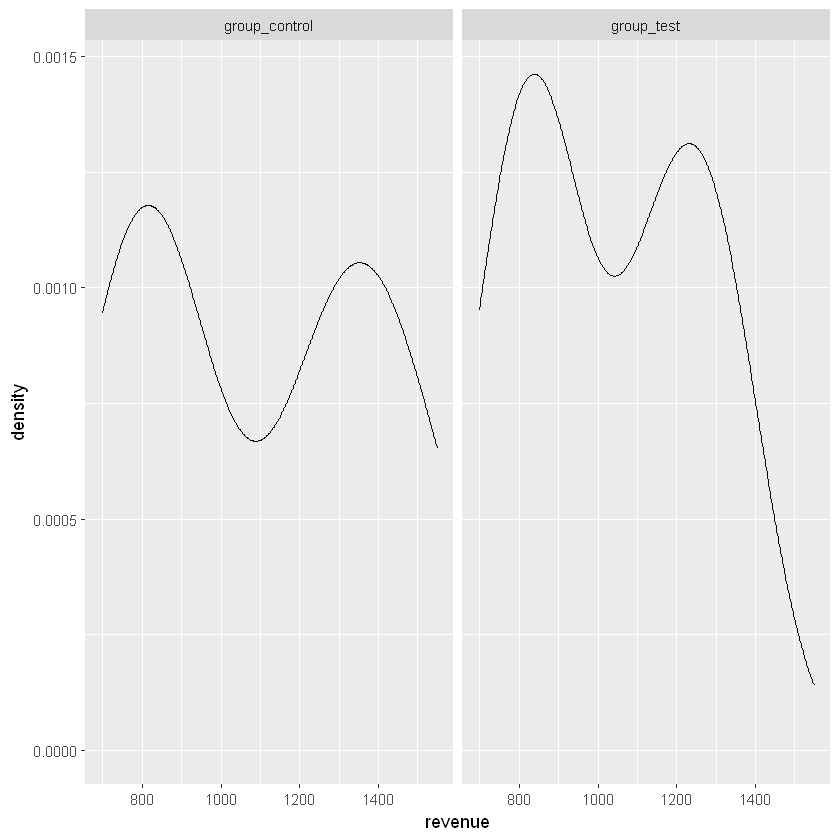

In [9]:
# Visualization with point and density plots
# Process and visualization in the same pipeline

library(ggplot2)
library(lubridate)
data_clean %>% group_by(dateActivity,abTestGroup,platform) %>%
   summarize(revenue=sum(cost)) %>% 
   ggplot(aes(x=wday(dateActivity),y=revenue)) + 
          geom_point() + facet_wrap(~ abTestGroup)

data_clean %>% group_by(dateActivity,abTestGroup,platform) %>%
   summarize(revenue=sum(cost)) %>% 
   ggplot(aes(x=revenue)) + 
          geom_density() + facet_wrap(~ abTestGroup)


In [10]:
# Transforming data for the t-test, calculating ARPDAU for both conditional groups.

ab_test_results <- data_clean %>%
  group_by(dateActivity,abTestGroup) %>%
  summarize(revenue=sum(cost),daily_users=n_distinct(userId),rdau=sum(cost)/n_distinct(userId))
head(ab_test_results)
ab_test_results %>% group_by(abTestGroup) %>%
  summarize(ARPDAU=mean(rdau))

# ARPDAU for control group ~ 0.059
# ARPDAU for test group ~ 0.056

dateActivity,abTestGroup,revenue,daily_users,rdau
2018-12-07,group_control,2095.388,32255,0.06496320
2018-12-07,group_test,1906.984,32095,0.05941686
2018-12-08,group_control,2065.312,34842,0.05927651
2018-12-08,group_test,2132.654,35176,0.06062810
2018-12-09,group_control,2102.670,36504,0.05760108
2018-12-09,group_test,1888.720,36640,0.05154803


abTestGroup,ARPDAU
group_control,0.05990093
group_test,0.05647726


In [11]:
### Statistical Signifance Test:

# We use a t-test since we have a continious outcome as revenue.
# Revenue per daily active user is explained by our condition.

library(stats)
stat_significance <- t.test(rdau ~ abTestGroup,
                         data = ab_test_results)
stat_significance


	Welch Two Sample t-test

data:  rdau by abTestGroup
t = 2.2117, df = 11.585, p-value = 0.04789
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 3.752617e-05 6.809823e-03
sample estimates:
mean in group group_control    mean in group group_test 
                 0.05990093                  0.05647726 


In [12]:
### Result: ###
# Our new layout is not as successful as we expected.
# p-value = 0.04789 -> Our test is statistically significant.
# We can say that, there is strong evidence, that this new layout does not help increasing purchases on our shop.


In [13]:
### Check-points:

# How was the basic conversions? Different perspective for user activity?

data_clean %>% mutate(conv=case_when(cost==0 ~ 0,
                              cost>0 ~ 1)) %>%
  group_by(abTestGroup) %>%
  summarize(conversion=mean(conv))

# Control group seems even better in purchasing(or not) conversions.

abTestGroup,conversion
group_control,0.07660468
group_test,0.07054172


platform,num_users,revenue,user_perc,revenue_perc
Android,150506,18225.76,0.7617664,0.6146742
iOS,47069,11425.33,0.2382336,0.3853258


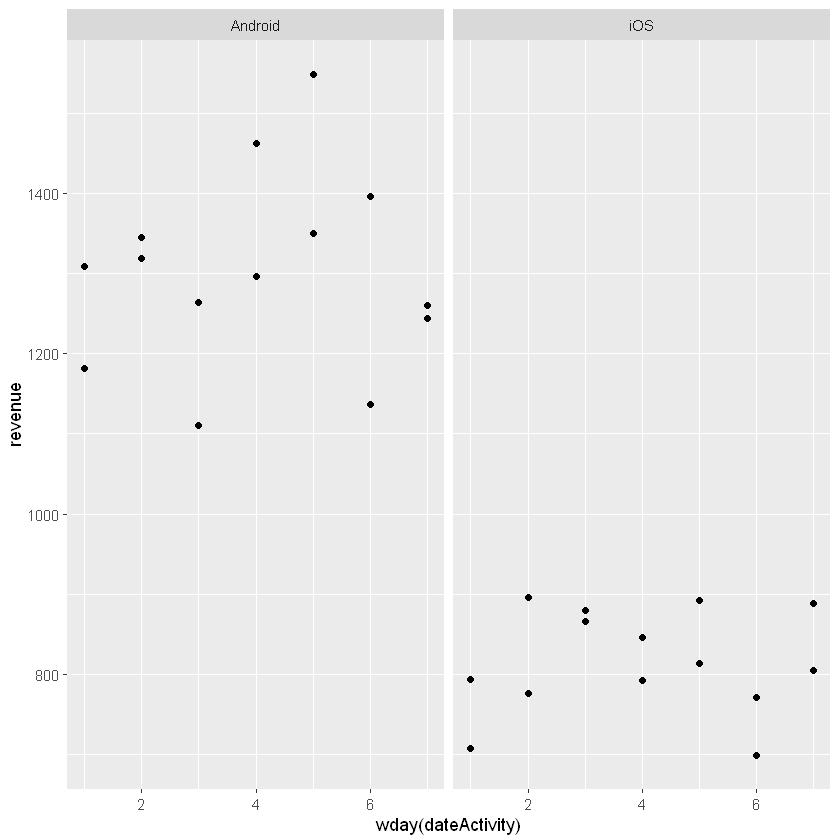

In [14]:
# How was the user activity distribution by platform?
data_clean %>% group_by(platform) %>% summarize(num_users=n_distinct(userId), revenue=sum(cost)) %>%
mutate(user_perc=num_users/sum(num_users), revenue_perc=revenue/sum(revenue))

data_clean %>% group_by(dateActivity,abTestGroup,platform) %>%
   summarize(revenue=sum(cost)) %>% 
   ggplot(aes(x=wday(dateActivity),y=revenue)) + 
          geom_point() + facet_wrap(~ platform)

# It seems that we are way more strong in Android user base than we are in IOS.
# Anroid: While our unique user percentage was 76% , it brings a smaller value of 61% of our revenue.
# IOS: While our unique user percentage was 23% , it brings a better 38% of our revenue.

# Not surprisingly our IOS user base is more "payable", just like the industry averages.
# Therefore, we can focus on even better user acquisition on IOS platform, optimizing the market based costs and other facts.

In [15]:
# How was our multi-market structure?
# Which countries had the most impact in our revenues this week?

sum(data_clean$cost)
data_clean %>% 
  group_by(countryCode) %>%
  summarize(revenue=sum(cost)) %>%
  arrange(desc(revenue)) %>%
  mutate(cumsum=cumsum(revenue)) %>%
  mutate(cumsum_perc=cumsum/29651) %>%
  filter(cumsum_perc<0.80)

# It seems that US and GB generates nearly our 50% of global revenue alone.
# Let's check if there was any interesting activitiy during the AB Test.

data_clean %>%
  group_by(dateActivity,abTestGroup,countryCode) %>%
  summarize(revenue=sum(cost),daily_users=n_distinct(userId),rdau=sum(cost)/n_distinct(userId)) %>%
  group_by(countryCode,abTestGroup) %>%
  summarize(ARPDAU=mean(rdau)) %>%
  filter(countryCode %in% c("US","GB"))

# GB reflected better reaction to the test design, but that did not significantly effect the results as a whole. 


[1] 29651.09

countryCode,revenue,cumsum,cumsum_perc
US,11342.418,11342.42,0.3825307
GB,3232.084,14574.50,0.4915349
IN,1670.990,16245.49,0.5478902
BR,1325.352,17570.84,0.5925886
ID,948.166,18519.01,0.6245661
DE,816.260,19335.27,0.6520950
AU,798.320,20133.59,0.6790189
SA,678.240,20811.83,0.7018930
CA,651.186,21463.02,0.7238547
FR,574.916,22037.93,0.7432441


countryCode,abTestGroup,ARPDAU
GB,group_control,0.1009618
GB,group_test,0.1060468
US,group_control,0.1262741
US,group_test,0.1224184


In [16]:
### Where to go from here? Questions that should be asked!

# Any Confounding Variables during the test?
# Any other major re-design on the game, during the test?
# Any campaign started or finished during the test, special price etc.

# A follow-up experiment: Since AB Testing is a continious loop, can we design a new experiment?